In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py


import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
import seaborn as sns
import time

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
train_directory='/content/drive/MyDrive/burung/BENTO/train'
test_directory='/content/drive/MyDrive/burung/BENTO/test'
val_directory='/content/drive/MyDrive/burung/BENTO/valid'

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
folders = glob('/content/drive/MyDrive/burung/BENTO/train/*')
len(folders)

31

In [ ]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(31, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 31)                7967      
                                                                 
Total params: 41,069,919
Trainable params: 26,355,231
No

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/burung/bento_nodrop.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                           verbose=1)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
epochs = 10

train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        val_directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 4972 images belonging to 31 classes.
Found 155 images belonging to 31 classes.
Found 155 images belonging to 31 classes.


In [ ]:
r = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stop],
    verbose=2
)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.78710, saving model to /content/drive/MyDrive/burung/bento_nodrop.h5
156/156 - 2341s - loss: 2.1467 - accuracy: 0.4302 - val_loss: 0.8488 - val_accuracy: 0.7871 - 2341s/epoch - 15s/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.78710 to 0.81935, saving model to /content/drive/MyDrive/burung/bento_nodrop.h5
156/156 - 78s - loss: 0.9273 - accuracy: 0.7496 - val_loss: 0.5733 - val_accuracy: 0.8194 - 78s/epoch - 503ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.81935 to 0.88387, saving model to /content/drive/MyDrive/burung/bento_nodrop.h5
156/156 - 83s - loss: 0.5929 - accuracy: 0.8337 - val_loss: 0.3314 - val_accuracy: 0.8839 - 83s/epoch - 534ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.88387 to 0.89032, saving model to /content/drive/MyDrive/burung/bento_nodrop.h5
156/156 - 84s - loss: 0.4031 - accuracy: 0.8938 - val_loss: 0.3110 - val_accuracy: 0.8903 - 84s/epoch - 538ms/step
Epoch 5/10

Epoch 5: 

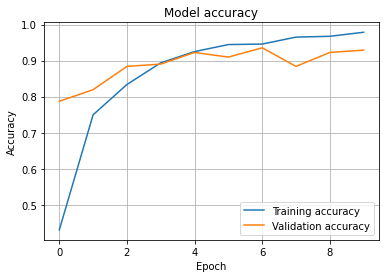

Mean Training Accuracy: 0.8634
Mean Validation Accuracy: 0.8884


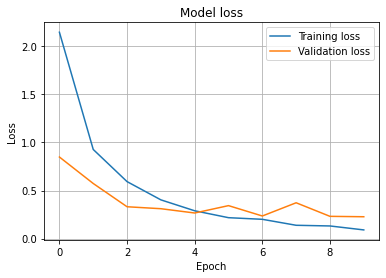

Mean Training Loss: 0.5139
Mean Validation Loss: 0.3741


In [ ]:
# Plot the training and validation accuracy
plt.plot(r.history['accuracy'], label='Training accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Print the mean accuracy and mean validation accuracy
print("Mean Training Accuracy: {:.4f}".format(np.mean(r.history['accuracy'])))
print("Mean Validation Accuracy: {:.4f}".format(np.mean(r.history['val_accuracy'])))


# Plot the training and validation loss
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Print the mean loss and mean validation loss
print("Mean Training Loss: {:.4f}".format(np.mean(r.history['loss'])))
print("Mean Validation Loss: {:.4f}".format(np.mean(r.history['val_loss'])))

In [ ]:
# Evaluate the model on the test set using a generator
loss, accuracy = model.evaluate(test_generator, use_multiprocessing=True, workers=10)

# Print the evaluation results
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Test loss: 0.2278
Test accuracy: 0.9419


In [ ]:
# model.save('/content/drive/MyDrive/burung/BENTO.h5')

Found 155 images belonging to 31 classes.
Accuracy Testing :  0.9290322580645162
Precision Testing :  0.9470967741935484
Recall Testing :  0.9290322580645162
F1 Score Testing :  0.9282606282606282

Confusion Matrix


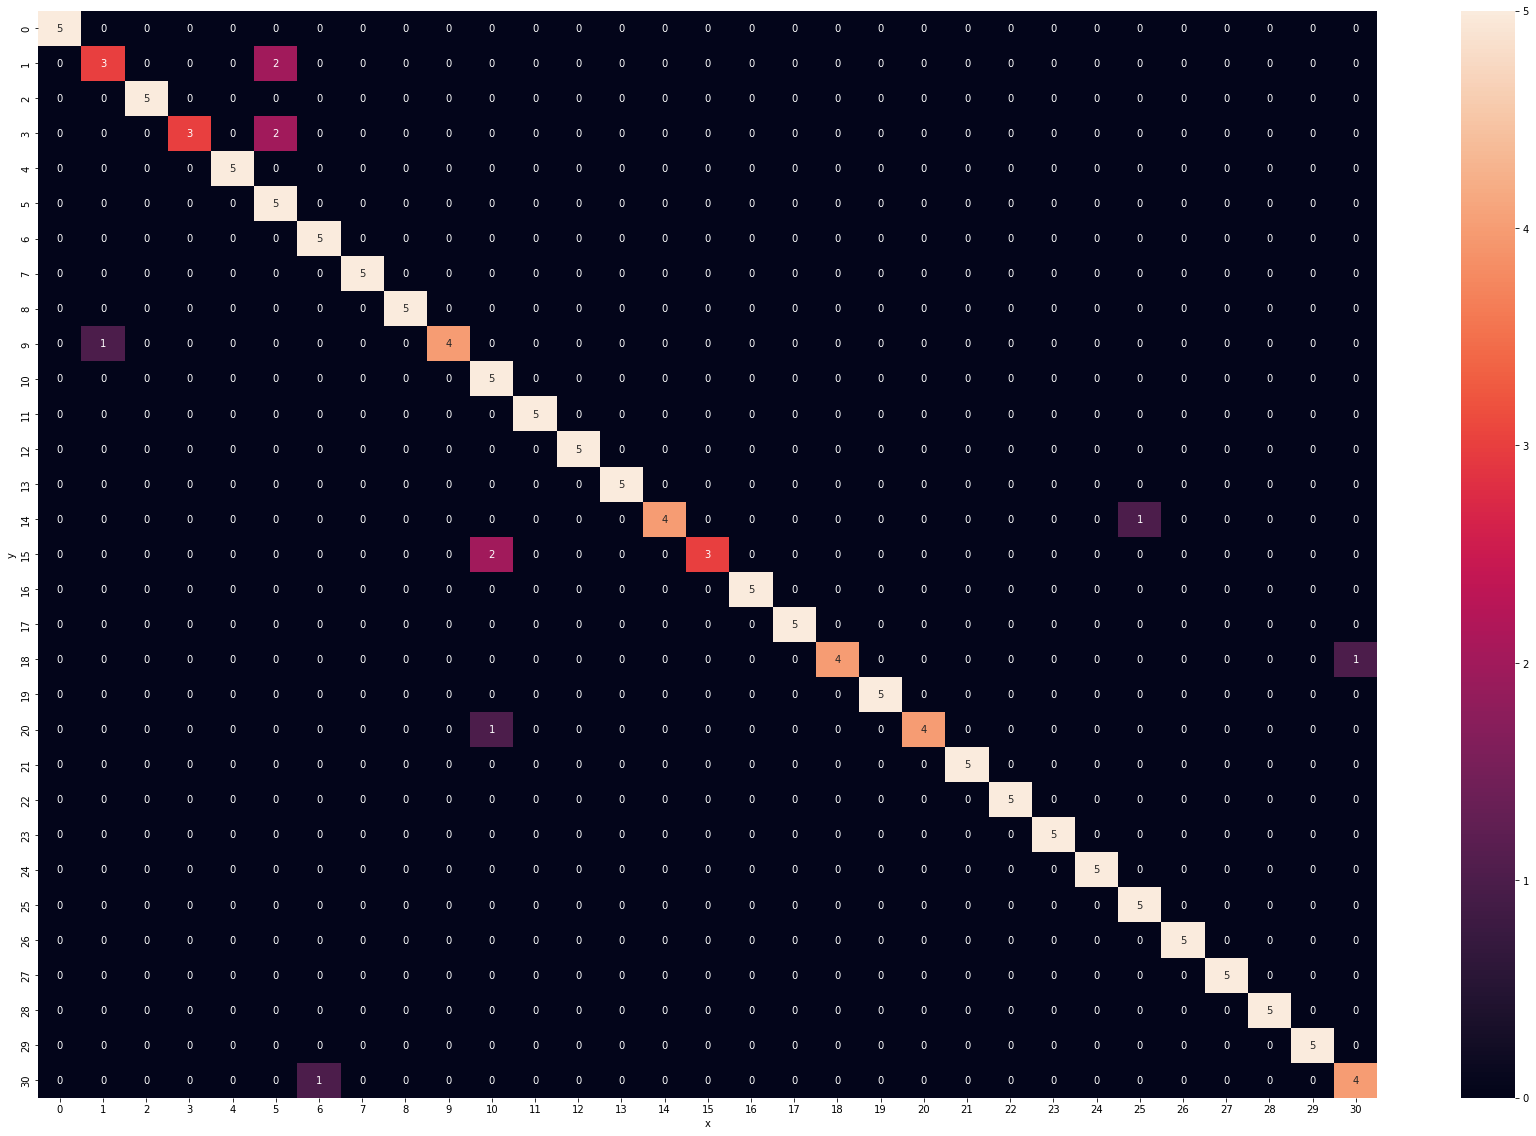



                        precision    recall  f1-score   support

       ALAP-ALAP KAWAH       1.00      1.00      1.00         5
  ANGSA-BATU CHRISTMAS       0.75      0.60      0.67         5
     ANGSA-BATU TOPENG       1.00      1.00      1.00         5
         BELIBIS TOTOL       1.00      0.60      0.75         5
 BIRU-LAUT EKOR-BLOROK       1.00      1.00      1.00         5
            BOHA WASUR       0.56      1.00      0.71         5
     BUNTUT-SATE PUTIH       0.83      1.00      0.91         5
   BURUNG-KUCING TUTUL       1.00      1.00      1.00         5
  CAMAR-ANGGUK COKELAT       1.00      1.00      1.00         5
   CAMAR-KEJAR POMARIN       1.00      0.80      0.89         5
           CEREK BESAR       0.62      1.00      0.77         5
        CIKALANG BESAR       1.00      1.00      1.00         5
        CINENEN GUNUNG       1.00      1.00      1.00         5
      DARA-LAUT KASPIA       1.00      1.00      1.00         5
           ELANG TIRAM       1.00    

In [ ]:
# Define path to models directory
model_path = '/content/drive/MyDrive/burung/bento_nodrop.h5'

# Define test data directory
test_data_dir = '/content/drive/MyDrive/burung/test bento'

test_datagen = ImageDataGenerator(rescale=1./255)


# Initialize list to store evaluation results
eval_results = []

# Load model
model = load_model(model_path)

# Generate test data generator
test_generator = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224, 224),
        batch_size=8,
        class_mode='categorical',
        shuffle=False)


# Generate predictions
test_predictions = np.argmax(model.predict(test_generator), axis=-1)
test_labels = test_generator.classes

# Evaluate metrics
acc_test = accuracy_score(test_predictions, test_labels)
prec_test = precision_score(test_predictions, test_labels, average = 'weighted')
rec_test = recall_score(test_predictions, test_labels, average = 'weighted')
f1score_test = f1_score(test_predictions, test_labels, average = 'weighted')

loss, acc = model.evaluate(test_generator,steps=len(test_generator),verbose=0)

# Create confusion matrix
conf_mat = confusion_matrix(test_labels, test_predictions)

# Save evaluation results to list
eval_results.append({
    'accuracy': acc_test,
    'precision': prec_test,
    'recall': rec_test,
    'f1_score': f1score_test,
    'loss':loss,
    'confusion_matrix': conf_mat
})

# Print evaluation results
print("Accuracy Testing : ",acc_test)
print("Precision Testing : ",prec_test)
print("Recall Testing : ",rec_test)
print("F1 Score Testing : ",f1score_test)
print("\nConfusion Matrix")
f, axis = plt.subplots(figsize=(30,20))
sns.heatmap(confusion_matrix(test_labels, test_predictions), annot=True, fmt=".0f", ax=axis)
plt.xlabel("x")
plt.ylabel("y")

plt.show()
print("\n")

#set class
print(classification_report(test_labels, test_predictions, target_names=['ALAP-ALAP KAWAH', 'ANGSA-BATU CHRISTMAS', 'ANGSA-BATU TOPENG', 'BELIBIS TOTOL', 'BIRU-LAUT EKOR-BLOROK', 'BOHA WASUR', 'BUNTUT-SATE PUTIH', 'BURUNG-KUCING TUTUL', 'CAMAR-ANGGUK COKELAT', 'CAMAR-KEJAR POMARIN', 'CEREK BESAR', 'CIKALANG BESAR', 'CINENEN GUNUNG', 'DARA-LAUT KASPIA', 'ELANG TIRAM', 'GAJAHAN PENGGALA', 'IBIS ROKOROKO', 'JUNAI EMAS', 'KAREO PADI', 'KASUARI GELAMBIR-GANDA', 'KEDIDI LEHER-MERAH', 'KEDIDIR BELANG', 'LAYANG-LAYANG ASIA', 'PECUK-ULAR AUSTRALASIA', 'PERKICI PELANGI', 'PERKUTUT JAWA', 'PIPIT BENGGALA', 'SERAK JAWA', 'TAK DIKETAHUI', 'TIKUSAN ALIS-PUTIH', 'TRULEK TOPENG']))
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')
